In [1]:
import os
import numpy as np
import networkx as nx
from networkx.algorithms.components import connected_components as connected_components
import pickle
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
#
DATA_FOLDER = 'data/'

In [2]:
def get_random_connected_motif(nodes_per_graph,num_edges,random_motif_size):
    if random_motif_size:
        num_edges = np.random.randint(2,num_edges+1)
    min_nodes = int(np.ceil((1+np.sqrt(1+8*num_edges))/2))
    num_nodes = np.random.randint(min_nodes,num_edges+2)
    while True:
        tmp = nx.empty_graph()
        edges = [(a,b) for a in range(num_nodes) for b in range(a+1,num_nodes)]
        assert len(edges) >= num_edges
        while True:
            n1,n2 = edges[np.random.randint(len(edges))]
            tmp.add_edge(n1,n2)
            edges.remove((n1,n2))
            if len(tmp.edges)==num_edges:
                break
        if nx.is_connected(tmp):
            node_ids = np.random.choice(range(nodes_per_graph),len(tmp),replace=False)
            tmp = nx.relabel.relabel_nodes(tmp,dict(zip(range(nodes_per_graph),node_ids)))
            return tmp

In [3]:
def add_pattern_inplace(graph,motif):
    for edge in motif.edges:
        graph.add_edge(*edge)

def remove_pattern_inplace(graph,motif):
    for edge in motif.edges:
        if edge in graph.edges:
            graph.remove_edge(*edge) 

In [4]:
def mutate(base_graph,perturbation_prob,motifs_to_add,motifs_to_remove):
    new_graph = base_graph.copy()
    for motif in motifs_to_add:
        if np.random.rand()<perturbation_prob:
            add_pattern_inplace(new_graph,motif)
    for motif in motifs_to_remove:
        if np.random.rand()<perturbation_prob:
            remove_pattern_inplace(new_graph,motif)
    return new_graph

In [5]:
def plot_motifs(motifs,num_cols=5):
    num_rows = len(motifs)//num_cols
    plt.figure(figsize=(16,3*num_rows))
    for indx,g in enumerate(motifs):
        plt.subplot(num_rows,num_cols,indx+1)
        nx.draw_networkx(g,node_color='orangered' if indx%2==0 else 'dodgerblue')
        plt.title(str(len(list(g.edges)))+' edges, class '+str(indx%2))    

In [6]:
def make_base_graph(nodes_per_graph,graph_density):
    base_graph = nx.empty_graph()
    for node in range(nodes_per_graph):
        base_graph.add_node(node)
    for edge in nx.erdos_renyi_graph(nodes_per_graph,graph_density).edges:
        base_graph.add_edge(*edge)
    return base_graph

In [7]:
def make_dataset(graphs_per_class,nodes_per_graph,graph_density,
                        motif_num,motif_size,random_motif_size,perturbation_prob):
    motifs = [get_random_connected_motif(nodes_per_graph,motif_size,random_motif_size) for _ in range(motif_num)]
    motifs = sorted(motifs, key=lambda m: len(m.edges))
    motifs_0 = motifs[0::2]
    motifs_1 = motifs[1::2] 
    #
    graphs_0 = [mutate(make_base_graph(nodes_per_graph,graph_density),perturbation_prob,\
                          motifs_0,motifs_1) for _ in range(graphs_per_class)]
    graphs_1 = [mutate(make_base_graph(nodes_per_graph,graph_density),perturbation_prob,\
                          motifs_1,motifs_0) for _ in range(graphs_per_class)]
    return graphs_0,graphs_1,motifs

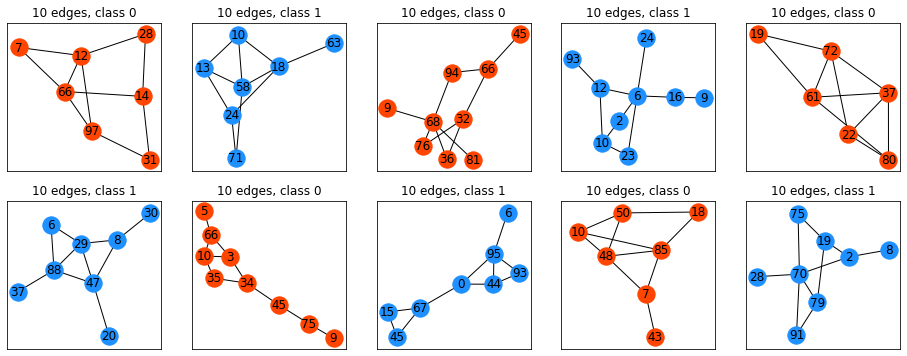

In [8]:
#Generate small dataset with fixed motif size
graphs_0,graphs_1,motifs = make_dataset(graphs_per_class=100,nodes_per_graph=100,graph_density=.2,\
                    motif_num=10,motif_size=10,random_motif_size=False,perturbation_prob=.5)
plot_motifs(motifs)

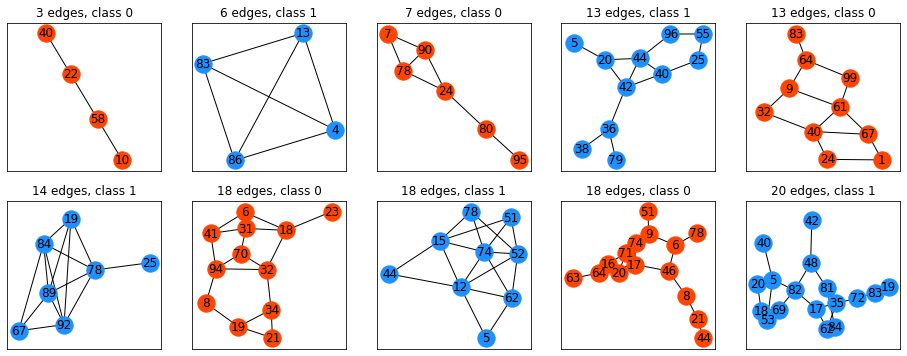

In [9]:
#Generate small dataset with variable motif size
graphs_0,graphs_1,motifs = make_dataset(graphs_per_class=100,nodes_per_graph=100,graph_density=.2,\
                    motif_num=10,motif_size=20,random_motif_size=True,perturbation_prob=.5)
plot_motifs(motifs)

In [10]:
def check_classes(graphs_0,graphs_1):
    num_nodes = len(graphs_0[0])
    for graphs_class,class_label in zip([graphs_0,graphs_1],['class_0','class_1']):
        class_density = np.mean([len(g.edges)/(num_nodes*num_nodes/2) for g in graphs_class])
        class_unique = len(set([a for b in [g.edges for g in graphs_class] for a in b]))
        print(class_label,len(graphs_class),'elems,',class_unique,'unique edges - density',class_density)
    plt.figure(figsize=(16,4))
    plt.hist([len(g.edges) for g in graphs_0],alpha=.5,label='Class_0')
    plt.hist([len(g.edges) for g in graphs_1],alpha=.5,label='Class_1')
    plt.legend()
    plt.title('Distribution of number-of-edges per graph')

class_0 100 elems, 4950 unique edges - density 0.20105599999999998
class_1 100 elems, 4950 unique edges - density 0.202722


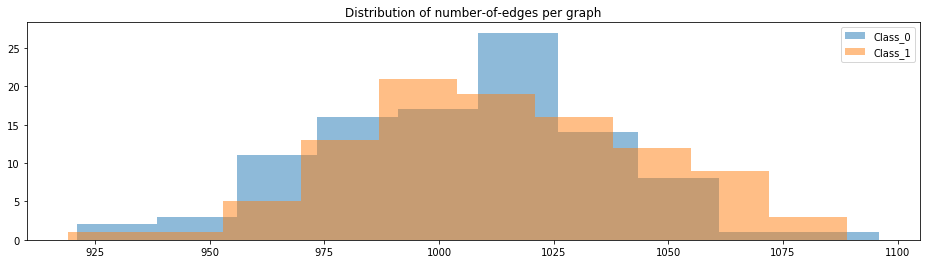

In [11]:
check_classes(graphs_0,graphs_1)

In [12]:
#generate and save a dataset
graphs_0,graphs_1,motifs = make_dataset(graphs_per_class=100,nodes_per_graph=100,graph_density=.2,\
                    motif_num=5,motif_size=10,random_motif_size=False,perturbation_prob=.2)
#
dump_name = 'p20s10n05'
pickle.dump(graphs_0, open(DATA_FOLDER+'synth_'+dump_name+'_0','wb'))
pickle.dump(graphs_1, open(DATA_FOLDER+'synth_'+dump_name+'_1','wb'))
pickle.dump(motifs,open(DATA_FOLDER+'injected_'+dump_name,'wb'))

# Experiment 5.1

In [13]:
def jaccard_distance_function(graphA,graphB):
    edgesA,edgesB = graphA.edges,graphB.edges
    intersection = len(set(edgesA).intersection(set(edgesB)))
    union = len(set(edgesA).union(set(edgesB)))
    return 1-intersection/union

def jaccard_matrix(graphs_0,graphs_1):
    dataset = graphs_0+graphs_1
    total_size = len(dataset)
    jaccard_distance_matrix = np.full((total_size,total_size),-1,dtype=float)
    for i in range(total_size):
        for j in range(total_size):
            if j>i:
                jaccard_distance_matrix[i][j] = jaccard_distance_function(dataset[i],dataset[j])
    return jaccard_distance_matrix

def get_ks(graphs_0,graphs_1):
    jaccard_distance_matrix = jaccard_matrix(graphs_0,graphs_1)
    total_size = len(graphs_0+graphs_1)
    mid_point = len(graphs_0)
    same_distr = [jaccard_distance_matrix[i][j] for i in range(total_size) for j in range(total_size) \
                                              if j>i and not (i<mid_point and j>=mid_point)]
    diff_distr = [jaccard_distance_matrix[i][j] for i in range(mid_point) for j in range(mid_point,total_size)]    
    return ks_2samp(same_distr,diff_distr)[0]

In [14]:
def batch_measure_separability(graphs_per_class,nodes_per_graph,graph_density,\
                              motif_num_values,motif_size_values,perturbation_prob_values):
    logger = {}
    print('TOTAL',len(motif_num_values)*len(motif_size_values)*len(perturbation_prob_values),'experiments')
    indx = 0
    for motif_num in motif_num_values:
        for motif_size in motif_size_values:   
            for perturbation_prob in perturbation_prob_values:
                print(indx,end=' ')
                ks_scores = []
                for _ in range(30):
                    graphs_0,graphs_1,motifs = make_dataset(graphs_per_class,nodes_per_graph,\
                                graph_density,motif_num,motif_size,False,perturbation_prob)
                    ks_scores.append(get_ks(graphs_0,graphs_1))
                logger[(motif_num,motif_size,perturbation_prob)] = ks_scores
                indx+=1
    return logger

In [15]:
rerun_experiment = False
if rerun_experiment:
    logger = batch_measure_separability(graphs_per_class=100,nodes_per_graph=100,graph_density=.2,\
            motif_num_values=[5,10],motif_size_values=[2,7,12],perturbation_prob_values=[0,.2,.4,.6,.8,1])
    pickle.dump(logger,open(DATA_FOLDER+'logger','wb'))
else:
    logger = pickle.load(open(DATA_FOLDER+'logger','rb'))

In [16]:
def plot_separability(logger): 
    plt.figure(figsize=(8,4))
    ycolors = ['orangered','gold','limegreen','darkorange','dodgerblue','mediumblue']
    motif_num_values = sorted(list(set([k[0] for k in logger.keys()])))
    motif_size_values = sorted(list(set([k[1] for k in logger.keys()])))
    perturbation_prob_values = sorted(list(set([k[2] for k in logger.keys()])))
    for indx,(mn,ms) in enumerate([(mn,ms) for mn in motif_num_values for ms in motif_size_values]):
        yavg = [np.mean(logger[(mn,ms,itrx)]) for itrx in perturbation_prob_values]
        ymax = [np.max(logger[(mn,ms,itrx)]) for itrx in perturbation_prob_values]
        ymin = [np.min(logger[(mn,ms,itrx)]) for itrx in perturbation_prob_values]
        ycolor = ycolors[indx%(len(ycolors))]
        plt.plot(perturbation_prob_values, yavg, label=str(mn)+' motifs with size '+str(ms), color=ycolor)
        plt.fill_between(perturbation_prob_values, ymin, ymax, alpha=0.1, edgecolor=ycolor, facecolor=ycolor)
    plt.xlabel('Perturbation Probability')
    plt.ylabel('Classes Separability')
    plt.ylim(top=1.1,bottom=0)
    plt.legend()
    plt.tight_layout()

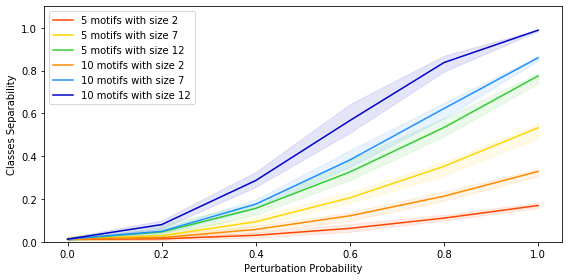

In [17]:
plot_separability(logger)